In [1]:
pip list | grep stalign

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd
import torch
import plotly
import requests
import scanpy as sc
import os

from STalign import STalign

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)
plt.rcParams['savefig.dpi'] = 300
#sc.settings.set_figure_params(dpi=300, dpi_save=300, format='pdf')

#Generate adata_concat with whole metabolite intensity information
RESOURCES_FOLDERNAME = '/data/project/AI4Omic/MASLD/data/MALDI/MSI.RMS'
RESULTS_FOLDERNAME = '/data/project/AI4Omic/MASLD/results/SM/STalign'
sc.settings.figdir = RESULTS_FOLDERNAME


samplefiles = {}
for filename in os.listdir(RESOURCES_FOLDERNAME):
    if filename.endswith('.txt'):
        sample_name = filename.split('_')[0]
        samplefiles[sample_name] = filename
print(samplefiles)
sample_list = list(samplefiles.keys())
sample_list

#Useful functions for adata generating from maldi raw sequencing file
def readOrifile(filename):
    nodefeatlabelsdict = {}
    f = open(filename)
    line = f.readline()
    tokens = line.strip().split('\t')
    nodefeatlabels = [float(i) for i in tokens[4:]]
    for i in range(len(nodefeatlabels)):
        nodefeatlabelsdict[float(nodefeatlabels[i])] = i
    xs = []
    ys = []
    nodefeats = []
    for line in f:
        if line.strip()!='':
            tokens = line.strip().split('\t')
            x = float(tokens[2])
            y = float(tokens[3])
            feat = tokens[4:]
            nodefeat = [float(k) for k in feat]
            xs.append(x)
            ys.append(y)
            nodefeats.append(nodefeat)
    return np.array(xs),np.array(ys),nodefeatlabels,nodefeatlabelsdict,np.array(nodefeats)

def genadata(xs,ys,nodefeats,sample,varindex):
    pos = np.stack((xs,ys),axis=-1)
    adata = sc.AnnData(X=nodefeats)
    adata.obsm['spatial'] = pos
    adata.uns['spatial'] = {sample: {}}
    adata.obs['sample'] = sample
    adata.var = varindex
    return adata

{'CTRL-180': 'CTRL-180_coordinates_intensities.txt', 'MASLD-1498': 'MASLD-1498_coordinates_intensities.txt', 'MASLD-4973': 'MASLD-4973_coordinates_intensities.txt', 'MASH-1475': 'MASH-1475_coordinates_intensities.txt', 'MASLD-1492': 'MASLD-1492_coordinates_intensities.txt', 'CTRL-179': 'CTRL-179_coordinates_intensities.txt', 'MASLD-1497': 'MASLD-1497_coordinates_intensities.txt', 'CTRL-5759': 'CTRL-5759_coordinates_intensities.txt', 'CTRL-161': 'CTRL-161_coordinates_intensities.txt', 'MASLD-1479': 'MASLD-1479_coordinates_intensities.txt', 'MASLD-9993': 'MASLD-9993_coordinates_intensities.txt', 'CTRL-8715': 'CTRL-8715_coordinates_intensities.txt', 'MASH-1494': 'MASH-1494_coordinates_intensities.txt', 'MASH-9136': 'MASH-9136_coordinates_intensities.txt', 'MASLD-1493': 'MASLD-1493_coordinates_intensities.txt', 'MASH-0422': 'MASH-0422_coordinates_intensities.txt', 'MASH-1481': 'MASH-1481_coordinates_intensities.txt', 'MASLD-1495': 'MASLD-1495_coordinates_intensities.txt', 'CTRL-5113': 'CTR

In [ ]:
adata = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/SM/Hotspot/adata.h5ad')

In [ ]:
# remove staggering
adata_maldi.obsm['spatial'][:,0] = adata_maldi.obsm['spatial'][:,0] - adata_maldi.obsm['spatial'][:,0].min()

In [ ]:
adata_maldi = adata[adata.obs['sample']==sample].copy()
from scipy.sparse import csr_matrix
adata_maldi.X = csr_matrix(adata_maldi.X) # 7925  pixels
sc.pl.spatial(adata_maldi, color='Module 11', img_key=None, spot_size=2, save = f'_{sample}_Before_QC.pdf', cmap='coolwarm', vmin='p5', vmax='p99')
adata_maldi = adata_maldi[adata_maldi.obs['Module 11']< np.quantile(adata_maldi.obs['Module 11'], 0.99)].copy()
sc.pl.spatial(adata_maldi, color='Module 11', img_key=None, spot_size=2, save = f'_{sample}_After_QC.pdf', cmap='coolwarm', vmin='p5', vmax='p99') # 7845  pixels

In [8]:
# three times rotation
#adata_maldi.obsm['spatial'] = np.column_stack((adata_maldi.obsm['spatial'][:, 1], adata_maldi.obsm['spatial'][:, 0].max() - adata_maldi.obsm['spatial'][:, 0]))

In [ ]:
sample = 'MASH-1494'
xs, ys, nodefeatlabels, nodefeatlabelsdict, nodefeats = readOrifile(os.path.join('/data/project/AI4Omic/MASLD/data/MALDI/MSI.RMS', samplefiles[sample]))
varindex = pd.DataFrame(index=nodefeatlabels).astype(str)
adata_maldi = genadata(xs, ys, nodefeats, sample, varindex)
adata_maldi.var_names = adata_maldi.var_names.astype(str)
adata_maldi.obs['disease_status'] = sample.split('-')[0]

from scipy.sparse import csr_matrix
adata_maldi.X = csr_matrix(adata_maldi.X)

# Use pca to remove data points that were located outside of the tissue sections
sc.pp.normalize_total(adata_maldi, inplace=True)
sc.pp.log1p(adata_maldi)
sc.pp.pca(adata_maldi)
sc.pp.neighbors(adata_maldi)
sc.tl.umap(adata_maldi)
sc.tl.leiden(adata_maldi, key_added="leiden", resolution=0.6)
sc.pl.spatial(adata_maldi, color='leiden', img_key=None, spot_size=2)

In [ ]:
adata_maldi = adata_maldi[~adata_maldi.obs['leiden'].isin(['1', '3']), :].copy()
sc.pl.spatial(adata_maldi, color='leiden', img_key=None, spot_size=2)

In [ ]:
# get cell centroid coordinates
xI = np.array(np.array(adata_maldi.obsm['spatial'][:, 1]))
yI = np.array(np.array(adata_maldi.obsm['spatial'][:, 0]))

# plot
fig,ax = plt.subplots()
ax.scatter(xI, yI, s=1, alpha=0.2, label='source')
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(f'{RESULTS_FOLDERNAME}/source.pdf', bbox_inches='tight')

0 of 7845
7844 of 7845


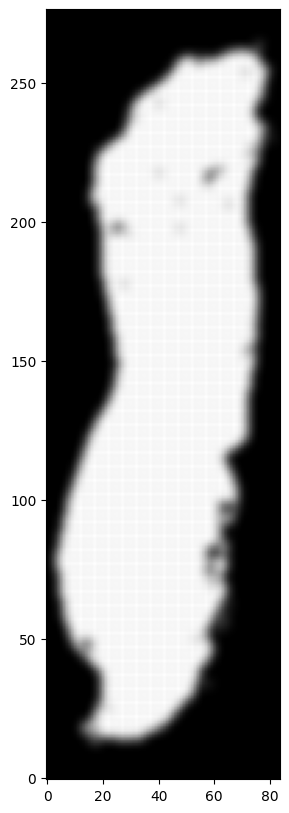

In [48]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XI, YI, I, fig = STalign.rasterize(xI, yI, dx=0.8)

ax = fig.axes[0]
ax.invert_yaxis()

In [49]:
# Note that this is a 1D greyscale image. To align with an RGB H&E image, we will need to make our greyscale image into RGB by simply stacking the 1D values 3 times. We will also normalize to get intensity values between 0 to 1.
print("The initial shape of I is {}".format(I.shape))
I = np.vstack((I, I, I)) # make into 3xNxM
print("The range of I is {} to {}".format(I.min(), I.max() ))

# normalize
I = STalign.normalize(I)
print("The range of I after normalization is {} to {}".format(I.min(), I.max() ))

# double check size of things
print("The new shape of I is {}".format(I.shape))

The initial shape of I is (1, 277, 84)
The range of I is 0.0 to 0.6577024329014767
The range of I after normalization is 0.0 to 1.0
The new shape of I is (3, 277, 84)


In [ ]:
# H&E image
image_file = f'/data/project/AI4Omic/MASLD/data/Rawdata/Visium/{sample}/outs/spatial/tissue_hires_image.png'
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

In [ ]:
V[300:1500, 900:1700] = V[1500,1000]
# plot
fig,ax = plt.subplots()
ax.imshow(V)

In [52]:
# Note that this is an RGB image that matplotlib.pyplot had read in as an NxMx3 matrix with values ranging from 0 to 1. We will use STalign to normalize the image in case there are any outlier intensities.
print("The initial shape of V is {}".format(V.shape))
print("The range of V is {} to {}".format(V.min(), V.max() ))

Vnorm = STalign.normalize(V)
print("The range of V after normalization is {} to {}".format(Vnorm.min(), Vnorm.max() ))

The initial shape of V is (1846, 2000, 3)
The range of V is 0.1725490242242813 to 0.9882352948188782
The range of V after normalization is 0.0 to 1.0


In [53]:
# We will transpose Vnorm to be a 3xNxM matrix J for downstream analyses. We will also create some variances YJ and XJ to keep track of the image size.
J = Vnorm.transpose(2,0,1)
print("The new shape of J is {}".format(J.shape))

YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

The new shape of J is (3, 1846, 2000)


In [ ]:
# We now have a rasterized image corresponding to the single cell positions from the spatial transcriptomics data and an H&E image that we can align. Note, that we have specified the image from cell positions as source I and the H&E image as target J

# get extent of images
extentJ = STalign.extent_from_x((YJ,XJ))
extentI = STalign.extent_from_x((YI,XI))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI)
ax[0].invert_yaxis()
ax[0].set_title('source', fontsize=15)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)
ax[1].set_title('target', fontsize=15)

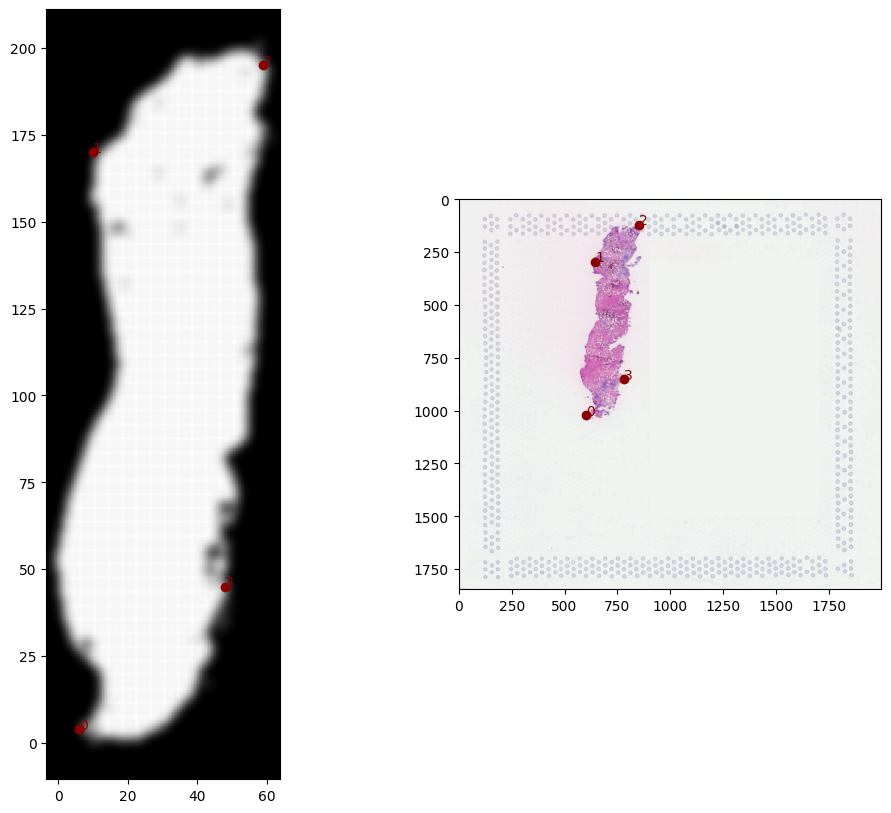

In [62]:
# STalign relies on an interative gradient descent to align these two images. This can be somewhat slow. We manually created 3 points that visually mark similar landmarks across the two datasets that we will use to initialize a simple affine alignment from the landmark points.
# We can double check that our landmark points look sensible by plotting them along with the rasterized image we created.
# manually make corresponding points
pointsI = np.array([[4., 6.], [170., 10.], [195., 59.], [45., 48.]])
pointsJ = np.array([[1020., 600.], [295., 645.], [120., 850.], [850., 780.]])

# plot
extentJ = STalign.extent_from_x((YJ,XJ))

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

ax[0].scatter(pointsI[:,1], pointsI[:,0], c='darkred')
ax[1].scatter(pointsJ[:,1], pointsJ[:,0], c='darkred')
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}', c='darkred')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}', c='darkred')

# invert only rasterized image
ax[0].invert_yaxis()

In [63]:
# From the landmark points, we can generate a linear transformation L and translation T which will produce a simple initial affine transformation A.
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointsI, pointsJ)
A = STalign.to_A(torch.tensor(L), torch.tensor(T))

In [ ]:
# We can show the results of the simple affine transformation.
# compute initial affine transformation from points
AI= STalign.transform_image_source_with_A(A, [YI,XI], I, [YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if AI.is_cuda:
    AI = AI.cpu()

fig,ax = plt.subplots(1,2)

ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extentJ)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

Text(0.5, 1.0, 'Landmark-based Affine Alignment')

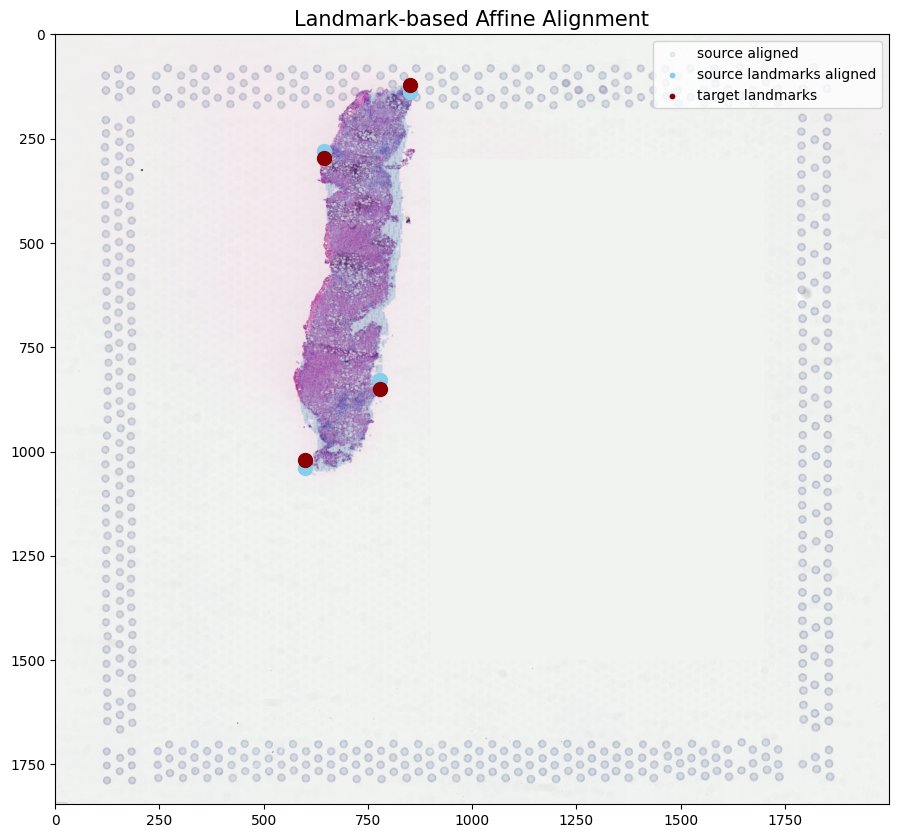

In [65]:
#apply A to sources points in row, column (y,x) orientation
affine = np.matmul(np.array(A.cpu()),np.array([yI, xI, np.ones(len(xI))]))

xIaffine = affine[1,:]
yIaffine = affine[0,:]


#apply A to sources landmark points in row, column (y,x) orientation
ypointsI = pointsI[:,0]
xpointsI = pointsI[:,1]
affine = np.matmul(np.array(A.cpu()), np.array([ypointsI, xpointsI, np.ones(len(ypointsI))]))

xpointsIaffine = affine[1,:]
ypointsIaffine = affine[0,:]
pointsIaffine = np.column_stack((ypointsIaffine,xpointsIaffine))


# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

ax.scatter(xIaffine,yIaffine,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(pointsIaffine[:,1],pointsIaffine[:,0],c="skyblue", label='source landmarks aligned', s=100)

ax.scatter(pointsJ[:,1],pointsJ[:,0], c='darkred', label='target landmarks', s=100)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

ax.set_title('Landmark-based Affine Alignment', fontsize=15)

/home/bailab/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/bailab/.local/lib/python3.10/site-packages/STalign/STalign.py:1301: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: user 9min 29s, sys: 1min 4s, total: 10min 33s
Wall time: 8min 48s


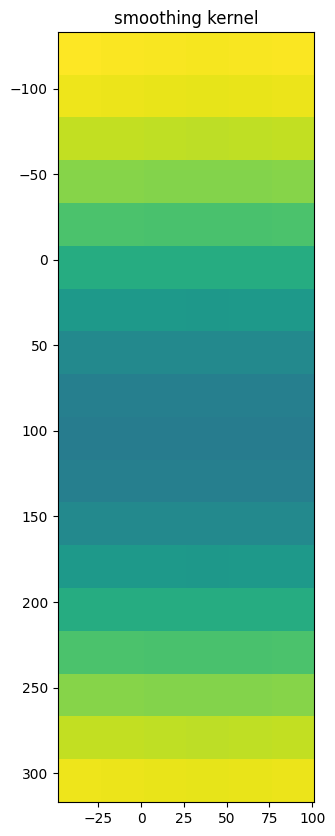

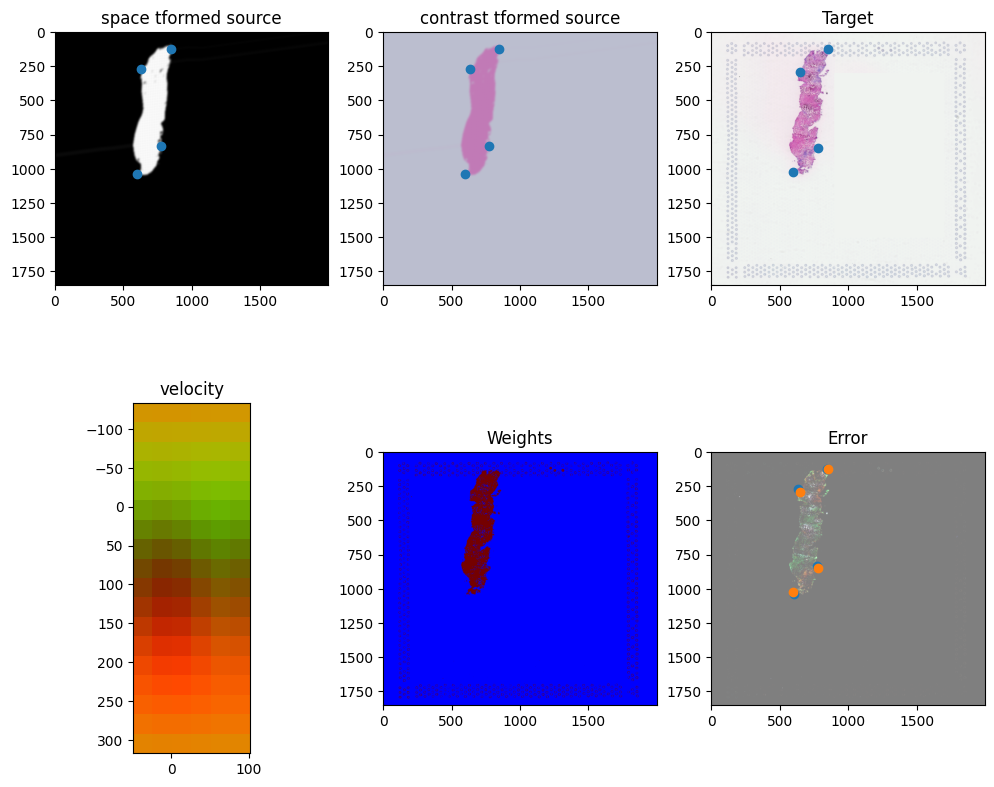

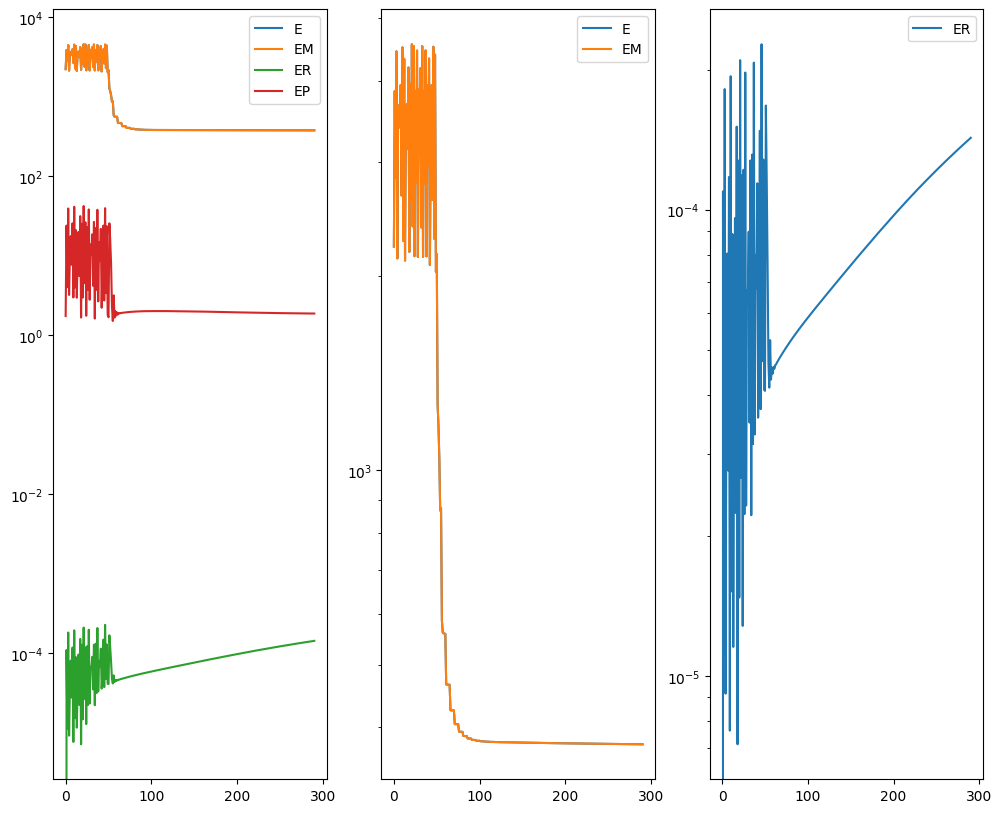

In [66]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
# keep all other parameters default
params = {'L':L,
          'T':T,
          'niter': 300,
          'pointsI': pointsI,
          'pointsJ': pointsJ,
          'device': device,
          'sigmaP': 2e-1,
          'sigmaM': 0.30,
          'sigmaB': 0.05,
          'sigmaA': 0.05,
          'diffeo_start' : 100,
          'epL': 5e-11,
          'epT': 5e-4,
          'epV': 5e1,
          #'muA': torch.tensor([0,0,0])
          }
params = {'L':L,
          'T':T,
          'niter': 300,
          'device':device,
          'pointsI': pointsI,
          'pointsJ': pointsJ,
          'sigmaM':1.5,
          'sigmaB':0.05,
          'sigmaA':0.05,
          'epV': 50,
          'muA': torch.tensor([0,0,0]), # black is background in source
          }
# a是一个间隔 太大后会导致某个维度只有一个值，导致报错
out = STalign.LDDMM(xI=[YI,XI], I=I, xJ=[YJ,XJ], J=J, v=None, xv=None, a=50, **params)

In [67]:
#### get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']
WM = out['WM']

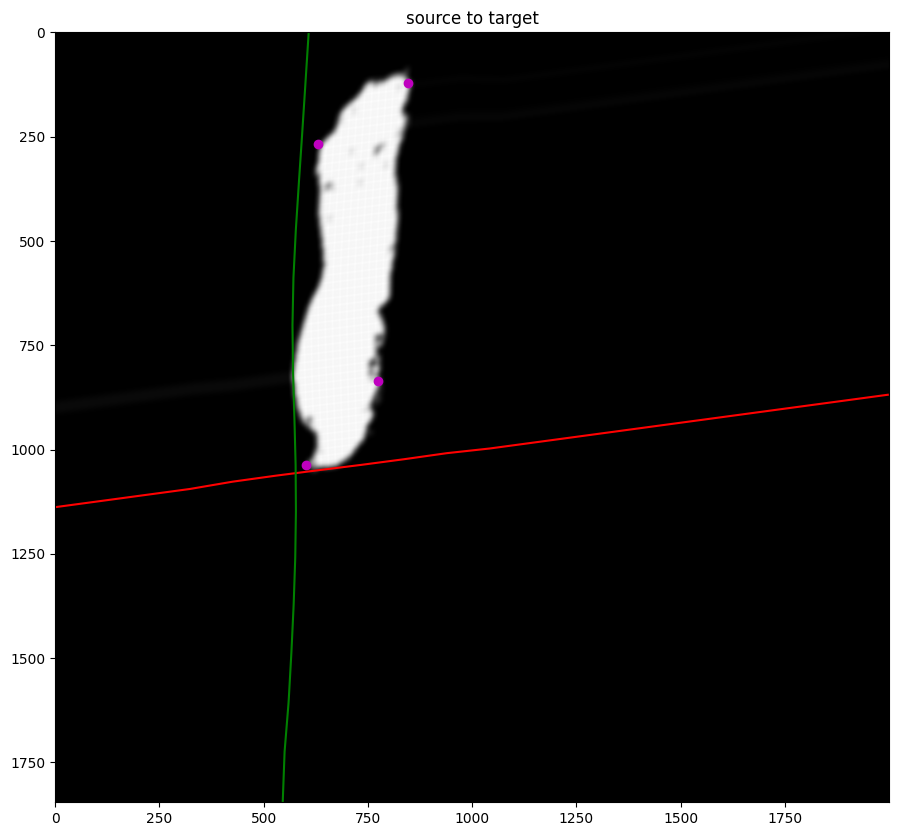

In [68]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
phiipointsI = STalign.transform_points_source_to_target(xv,v,A,pointsI)

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()
if phiipointsI.is_cuda:
    phiipointsI = phiipointsI.cpu()


# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)

ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')

ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="m")

In [69]:
# Finally, we can apply our transform to the original sets of single cell centroid positions to achieve their new aligned positions.
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

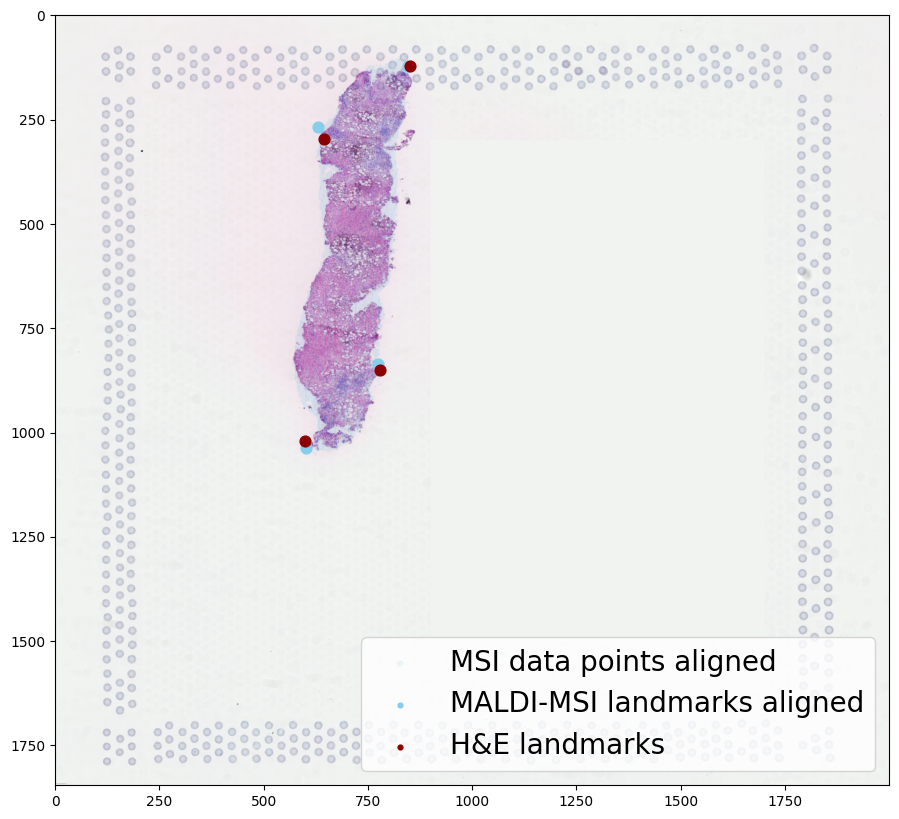

In [76]:
# plot results
fig,ax = plt.subplots()

ax.imshow((J).transpose(1,2,0),extent=extentJ)

ax.scatter(xI_LDDMM, yI_LDDMM, s=1, alpha=0.1, label = 'MSI data points aligned', c='skyblue')
ax.scatter(phiipointsI[:,1].detach(),phiipointsI[:,0].detach(),c="skyblue", label='MALDI-MSI landmarks aligned', s=60)

ax.scatter(pointsJ[:,1],pointsJ[:,0], c='darkred', label='H&E landmarks', s=60)
ax.set_aspect('equal')

lgnd = plt.legend(loc="lower right", scatterpoints=1, fontsize=20)
for handle in lgnd.legend_handles:
    handle.set_sizes([12.0])

#ax.set_title('After alignment aligned source and target with aligned pointsI and pointsJ', fontsize=15)
plt.savefig(f'{RESULTS_FOLDERNAME}/aligned.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Before alignment: source with pointsI')

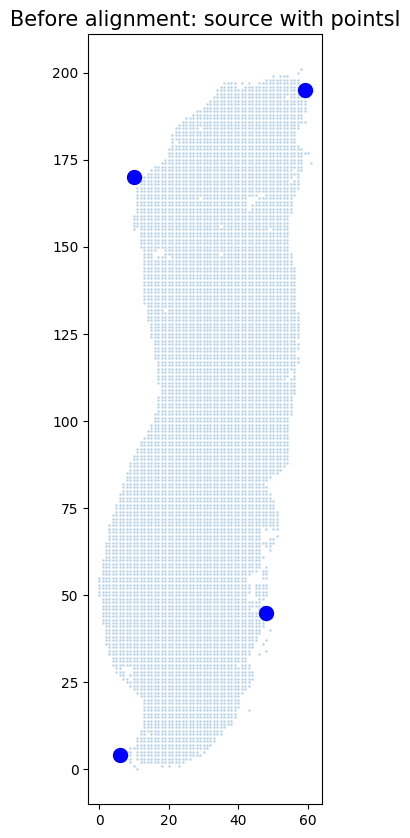

In [79]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2)
ax.set_aspect('equal', 'box')
ax.scatter(pointsI[:,1],pointsI[:,0], c='blue', s=100)
ax.set_title('Before alignment: source with pointsI', fontsize=15)

In [ ]:
#adata_maldi.obsm['spatial'] = np.column_stack((xI_LDDMM, yI_LDDMM))

In [80]:
adata_maldi.obs.loc[:, ['xI_LDDMM', 'yI_LDDMM']] =xI_LDDMM, yI_LDDMM

/home/bailab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return asarray(a).ndim
/home/bailab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [ ]:
# Load visium ST data from STAMP output
adata_visium = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/ST/STAMP/adata_stamp.h5ad')
adata_visium = adata_visium[adata_visium.obs['sample'] == sample, :].copy()

In [38]:
# Normalization
sc.pp.normalize_total(adata_visium, target_sum=1e4)
sc.pp.log1p(adata_visium)

In [137]:
beta = adata_visium.uns['beta'].copy()
topic_prop = adata_visium.uns['topic_prop'].copy()
# Find topic signature genes
topic_sig = {}
for topic in topic_prop.columns:
    topic_sig[topic] = beta.nlargest(100, topic).index.tolist()

In [138]:
topic_sig['Topic4']

['FABP4',
 'SPP1',
 'TREM2',
 'FABP5',
 'LPL',
 'LGALS3',
 'CD52',
 'PLA2G7',
 'CAPG',
 'CCL4L2',
 'MMP9',
 'LSP1',
 'CXCL9',
 'DHRS9',
 'RGCC',
 'GPNMB',
 'C15orf48',
 'EMILIN2',
 'LYZ',
 'ITGAX',
 'CXCL10',
 'CD83',
 'OTOA',
 'LGALS2',
 'RGS10',
 'LTB',
 'HLA-DQA1',
 'AC020656.1',
 'CD48',
 'HCST',
 'CCL18',
 'CCL4',
 'NCF2',
 'S100A11',
 'RAB7B',
 'MSR1',
 'BCL2A1',
 'CXCR4',
 'SLAMF7',
 'SLAMF8',
 'TYROBP',
 'EVI2A',
 'CCL3',
 'CD84',
 'HAVCR2',
 'UCP2',
 'HLA-DPA1',
 'RAC2',
 'S100A8',
 'IGSF6',
 'ITGB2',
 'BCAT1',
 'C5AR1',
 'LAIR1',
 'TRAC',
 'FCGR2A',
 'CCL3L1',
 'FPR3',
 'GLIPR1',
 'MMP19',
 'SLC1A3',
 'CCL5',
 'CD53',
 'CD44',
 'VIM',
 'HLA-DMB',
 'CD3D',
 'CD2',
 'FCN1',
 'BIRC3',
 'IFI30',
 'SPI1',
 'GLIPR2',
 'LILRB4',
 'HLA-DRA',
 'TRBC2',
 'LAPTM5',
 'HS3ST2',
 'LGALS9',
 'IL2RG',
 'HLA-DRB1',
 'PLEK',
 'HLA-DQB1',
 'UBD',
 'GZMA',
 'WDFY4',
 'CORO1A',
 'S100A9',
 'FGR',
 'HLA-DPB1',
 'S100A6',
 'S100A4',
 'PLXNC1',
 'CRIP1',
 'KLRB1',
 'ALOX5AP',
 'PILRA',
 'SASH3',
 'F

In [ ]:
adata_visium = adata_visium[adata_visium.obs['sample'] == sample, :].copy()
# Modify the spatial coordinates to match the LDDMM aligned maldi data
adata_visium.obs['hires_x_coordinates'] = adata_visium.obsm['spatial'][:, 0] * adata_visium.uns['spatial'][sample]['scalefactors']['tissue_hires_scalef']
adata_visium.obs['hires_y_coordinates'] = adata_visium.obsm['spatial'][:, 1] * adata_visium.uns['spatial'][sample]['scalefactors']['tissue_hires_scalef']

# remove one biopsy section
adata_visium = adata_visium[adata_visium.obs.hires_x_coordinates < 900, :].copy()
sc.pl.spatial(adata_visium, img_key='hires', color='sample', frameon=False, library_id=sample, alpha=0, title='', legend_loc=None, save=f'_{sample}.pdf')

In [ ]:
sc.pl.spatial(adata_visium[adata_visium.obs['Topic4'] > np.quantile(adata_visium.obs['Topic4'], 0.90)], img_key='hires', color='Topic4', frameon=False, library_id=sample, title='', legend_loc=None, colorbar_loc=None, save=f'_{sample}_Topic4.pdf')

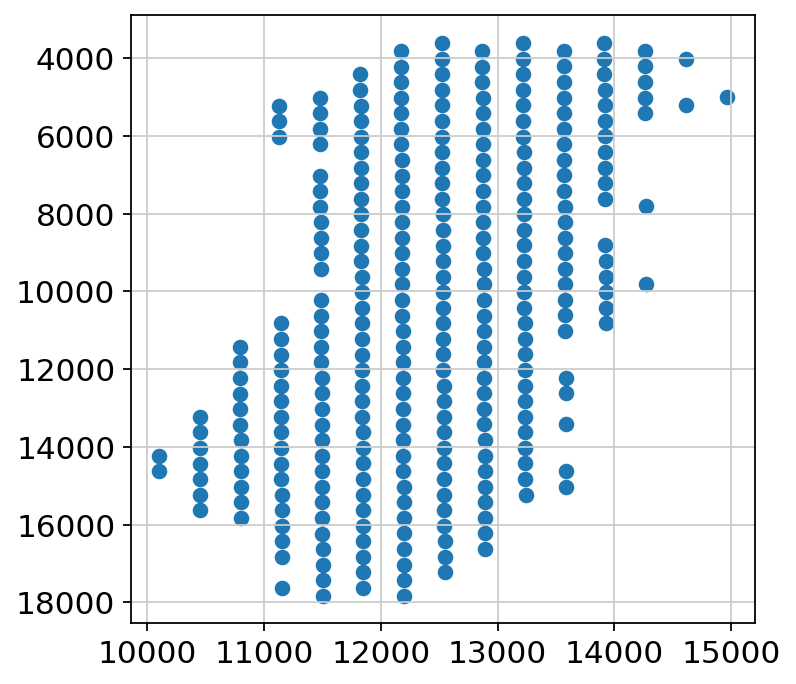

In [164]:
plt.scatter(x=adata_visium.obsm['spatial'][:, 0], y=adata_visium.obsm['spatial'][:, 1])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
sc.pl.spatial(adata_visium, color=['PLA2G7'], library_id=sample, cmap='RdBu_r', colorbar_loc=None, crop_coord=[11000, 12800, 13500, 15500], save=f'_{sample}_PLA2G7_2.pdf', frameon=False, title='', vmax='p95')

In [ ]:
sc.pl.spatial(adata_visium, color=['PLA2G7'], library_id=sample, cmap='RdBu_r', colorbar_loc=None, crop_coord=[11300, 13200, 9000, 11000], save=f'_{sample}_PLA2G7_1.pdf', frameon=False, title='', vmax='p95')

In [ ]:
sc.pl.spatial(adata_visium, color=['PLA2G7'], library_id=sample, cmap='RdBu_r', colorbar_loc=None, crop_coord=[11000, 14200, 9000, 6500], save=f'_{sample}_PLA2G7.pdf', frameon=False, title='', vmax='p95')

In [ ]:
adata_visium = sc.read_visium(path=(f'/data/project/AI4Omic/MASLD/data/Rawdata/Visium/{sample}/outs'), count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata_visium.var_names_make_unique()
adata_visium.obs['sample'] = sample
adata_visium.obs['disease_status'] = sample.split('-')[0]
adata_visium.obs['hires_x_coordinates'] = adata_visium.obsm['spatial'][:, 0] * adata_visium.uns['spatial'][sample]['scalefactors']['tissue_hires_scalef']
adata_visium.obs['hires_y_coordinates'] = adata_visium.obsm['spatial'][:, 1] * adata_visium.uns['spatial'][sample]['scalefactors']['tissue_hires_scalef']

# QC for genes and spots
sc.pp.filter_cells(adata_visium, min_counts=400)
sc.pp.filter_cells(adata_visium, min_genes=400)
sc.pp.filter_genes(adata_visium, min_cells=3)

# remove one biopsy section
adata_visium = adata_visium[adata_visium.obs.hires_y_coordinates > 1000, :].copy()

sc.pl.spatial(adata_visium, img_key='hires', color='sample', frameon=False)

In [85]:
adata_maldi.n_obs / adata_visium.n_obs

26.95876288659794

In [82]:
from scipy.spatial import cKDTree

# 获取adata_maldi和adata_visium的空间坐标
coords_maldi = adata_maldi.obs[['xI_LDDMM', 'yI_LDDMM']]
coords_visium = adata_visium.obs[['hires_x_coordinates', 'hires_y_coordinates']]

# 构建cKDTree
tree = cKDTree(coords_maldi)

# 查找每个adata_visium spot的最近10个adata_maldi points
distances, indices = tree.query(coords_visium, k=10)

In [83]:
adata_SG = adata_visium.copy()
mask = distances <= np.quantile(distances.flatten(), 0.95)
adata_SG = adata_SG[~(mask.sum(axis=1) == 0), :]
indices = indices[~(mask.sum(axis=1) == 0), :]
mask = mask[~(mask.sum(axis=1) == 0), :]

adata_SM = sc.AnnData(X=np.zeros((adata_SG.n_obs, adata_maldi.n_vars)), obs=adata_SG.obs.copy(), var=adata_maldi.var.copy(), uns=adata_SG.uns.copy(), obsm=adata_SG.obsm.copy())
# 对每个adata_visium spot，计算最近5个adata_maldi点的代谢谱平均
for i, idx in enumerate(indices):
    idx = idx[mask[i]]
    print(len(idx))
    adata_SM.X[i, :] = adata_maldi.X[idx, :].mean(axis=0)

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
2
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
9
10
10
10
10
5
10
10
10
10
10
10
10
10
10
10
10
10
8
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
5
10
10
10
10
10
10
10
10
10
10
10
10
1
10
10
10
10
10
10
10
10
10
3
10
10
10
10
10
10
10
10
10
5
10
5
6
10
10
10
10
10
10
10
10
8
10
10
10
10
10
10
5
10
3
10
10
10
10
10
9
10
10
10
10
10
10
10
10
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
7
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
3
10
10
10
10
10
10
10
10
10
10
10
10
10
10
7
10
10
10
10
10
10
10
10
10
10
10
10
5
10
10
10
10
10
10
10
10
10
10
10
10
10
6
10
10
10
10
9
10
10
10
10
10
10
10
10
10
10
10
10
10
5
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
9
10
10
10
10
10
10
8
2
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
6
10
10
10
10
10
10
10


In [92]:
from scipy.spatial import cKDTree

# 获取adata_maldi和adata_visium的空间坐标
coords_maldi = adata_maldi.obs[['xI_LDDMM', 'yI_LDDMM']]
coords_visium = adata_visium.obs[['hires_x_coordinates', 'hires_y_coordinates']]

# 构建cKDTree
tree = cKDTree(coords_visium)

# 查找每个adata_visium spot的最近1个adata_maldi points
distances, indices = tree.query(coords_maldi, k=1)

In [93]:
adata_SM = adata_maldi.copy()
for i in range(20):
    variable = f'Topic{i+1}'
    adata_SM.obs[variable] = adata_visium.obs[variable].values[indices]
    variable = f'Topic{i+1}_score'
    adata_SM.obs[variable] = adata_visium.obs[variable].values[indices]

In [123]:
adata_SM = adata_SM[distances < np.quantile(distances.flatten(), 0.95)].copy()

In [125]:
#WNN analysis
import seaborn as sns
cmap = sns.blend_palette(["#eefdff", '#239bb9', '#113847', '#fcb70c', "#f98d06"], as_cmap=True)

In [ ]:
with plt.rc_context({'font.size': 25}):
    sc.pl.spatial(adata_SM, color=['Module 5', 'Module 13'], spot_size=2, vmin='p5', vmax='p95', cmap='coolwarm', frameon=False, ncols=2, colorbar_loc=None, save=f'_{sample}_Module5_13.pdf')
    sc.pl.spatial(adata_SM, color=['Topic4', 'Topic5'], spot_size=2, vmin='p5', vmax='p95', cmap=cmap, frameon=False, ncols=2, colorbar_loc=None, save=f'_{sample}Topic4_5.pdf')

In [132]:
topic_sig['Topic4']

['FABP4',
 'SPP1',
 'TREM2',
 'FABP5',
 'LPL',
 'LGALS3',
 'CD52',
 'PLA2G7',
 'CAPG',
 'CCL4L2',
 'MMP9',
 'LSP1',
 'CXCL9',
 'DHRS9',
 'RGCC',
 'GPNMB',
 'C15orf48',
 'EMILIN2',
 'LYZ',
 'ITGAX',
 'CXCL10',
 'CD83',
 'OTOA',
 'LGALS2',
 'RGS10',
 'LTB',
 'HLA-DQA1',
 'AC020656.1',
 'CD48',
 'HCST',
 'CCL18',
 'CCL4',
 'NCF2',
 'S100A11',
 'RAB7B',
 'MSR1',
 'BCL2A1',
 'CXCR4',
 'SLAMF7',
 'SLAMF8',
 'TYROBP',
 'EVI2A',
 'CCL3',
 'CD84',
 'HAVCR2',
 'UCP2',
 'HLA-DPA1',
 'RAC2',
 'S100A8',
 'IGSF6',
 'ITGB2',
 'BCAT1',
 'C5AR1',
 'LAIR1',
 'TRAC',
 'FCGR2A',
 'CCL3L1',
 'FPR3',
 'GLIPR1',
 'MMP19',
 'SLC1A3',
 'CCL5',
 'CD53',
 'CD44',
 'VIM',
 'HLA-DMB',
 'CD3D',
 'CD2',
 'FCN1',
 'BIRC3',
 'IFI30',
 'SPI1',
 'GLIPR2',
 'LILRB4',
 'HLA-DRA',
 'TRBC2',
 'LAPTM5',
 'HS3ST2',
 'LGALS9',
 'IL2RG',
 'HLA-DRB1',
 'PLEK',
 'HLA-DQB1',
 'UBD',
 'GZMA',
 'WDFY4',
 'CORO1A',
 'S100A9',
 'FGR',
 'HLA-DPB1',
 'S100A6',
 'S100A4',
 'PLXNC1',
 'CRIP1',
 'KLRB1',
 'ALOX5AP',
 'PILRA',
 'SASH3',
 'F

In [72]:
adata_SM = adata_maldi.copy()
adata_SG = sc.AnnData(X=np.zeros((adata_SM.n_obs, adata_visium.n_vars)), obs=adata_SM.obs.copy(), var=adata_visium.var.copy(), uns=adata_SM.uns.copy(), obsm=adata_SM.obsm.copy())

# 对每个MSI point赋值最近的visium spot gene expression
for i, idx in enumerate(indices):
    adata_SG.X[i, :] = adata_visium.X[idx, :].mean(axis=0)

In [ ]:
adata_SG = adata_SG[distances < np.quantile(distances.flatten(), 0.95)].copy()
